#### Импорт библиотек

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from PIL import Image
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
from torch.nn import Upsample
from torchvision.transforms import Compose, ToTensor

#### Загрузка данных для обучения и формирование датасета

In [5]:
!gdown --id 1EdqTkztvFjVRu0tgplODmyG9dXwoyX1b
!gdown --id 1WE4Jb_orPxExM7vb8PtL_s3OUWoMW8Ux
! unzip train_hq.zip
! unzip train_masks.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1EdqTkztvFjVRu0tgplODmyG9dXwoyX1b
To: /content/train_hq.zip
100% 843M/843M [00:02<00:00, 292MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WE4Jb_orPxExM7vb8PtL_s3OUWoMW8Ux
To: /content/train_masks.zip
100% 30.5M/30.5M [00:00<00:00, 244MB/s]
Archive:  train_hq.zip
replace train_hq/a1038b207299_14.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train_masks.zip
replace train_masks/00087a6bd4dc_01_mask.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
files_hq = sorted(['train_hq/'+train_hq
    for train_hq in os.listdir('train_hq')
])
files_masks = sorted(['train_masks/'+train_masks
    for train_masks in os.listdir('train_masks')
])
print(len(files_hq),len(files_masks),
      '\n',files_masks[:5],'\n',files_hq[:5],)

5088 5088 
 ['train_masks/00087a6bd4dc_01_mask.gif', 'train_masks/00087a6bd4dc_02_mask.gif', 'train_masks/00087a6bd4dc_03_mask.gif', 'train_masks/00087a6bd4dc_04_mask.gif', 'train_masks/00087a6bd4dc_05_mask.gif'] 
 ['train_hq/00087a6bd4dc_01.jpg', 'train_hq/00087a6bd4dc_02.jpg', 'train_hq/00087a6bd4dc_03.jpg', 'train_hq/00087a6bd4dc_04.jpg', 'train_hq/00087a6bd4dc_05.jpg']


In [ ]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, files_hq: list, files_masks: list):
        """Initializes Dataset with passed list of files.
        Args:
            files: list of files,
            labels: list of labels.
        """
        self.files_hq = files_hq
        self.files_masks = files_masks

        self.to_tensor = transforms.ToTensor() 
        

    def __getitem__(self, idx: int):
        """Returns the object by given index.
        Args:
            idx - index of the file.
        Returns:
            processed image.
        """

        file = self.files_hq[idx]
        image_1 = cv2.imread(file)
        image_1 = cv2.resize(image_1, (512, 512))

        labels = self.files_masks[idx]
        cap = cv2.VideoCapture(labels)
        ret, image_2 = cap.read()
        image_2 = cv2.resize(image_2, (512, 512))
        
        return self.to_tensor(image_1), self.to_tensor(image_2)
        # return image_1, image_2
        
    def __len__(self):
        """Returns length of files containing in dataset."""
        
        return len(self.files_hq)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
data_train, data_val, label_train, label_val = train_test_split(files_hq[:1200], files_masks[:1200], test_size=0.2)
train_dataset = CarDataset(data_train, label_train)
val_dataset = CarDataset(data_val, label_val)
train_loader = DataLoader(train_dataset, batch_size=1,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1)

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(train_features.shape,train_labels.shape)
# img1 = tensor[0]
# save_image(img1, 'img1.png')

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


#### Визуализация данных

torch.Size([3, 512, 512]) 
 torch.Size([3, 512, 512])


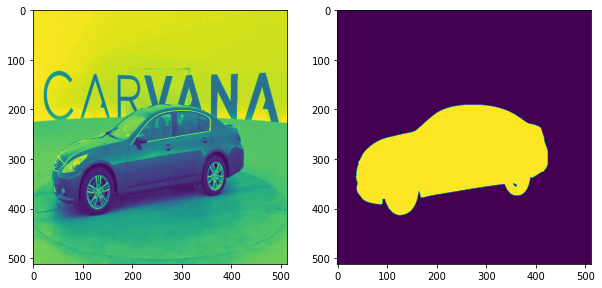

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
img, mask = train_dataset[0]
# print(im.detach().cpu().numpy().shape)
plt.imshow(img[0].detach().cpu().numpy())
plt.subplot(1,2,2)
mask = train_dataset[0][1]
plt.imshow(mask[0].detach().cpu().numpy())
print(
      img.shape,'\n',
      mask.shape,)

#### Функция подсчёта *Intersection over Union*

In [ ]:
def calc_iou(
    prediction: np.array,
    ground_truth: np.array
    ) -> np.array:
    """
    Function for computing IoU metrics.

    Args:
        prediction: batch of binarized predicted masks (either 0 or 1)
        ground_truth: batch of binary GT masks (either 0 or 1)
    Returns:
        calculated iou: np.array
    """
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

#### Модель *Unet*

In [ ]:
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        self.to_tensor = transforms.ToTensor()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=8, out_channels=out_channels, kernel_size=1
        )
        self.conv_last = nn.Conv2d(features, 8, kernel_size = 3, padding=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec1 = self.conv_last(dec1)
        dec1 = torch.sigmoid(self.conv(dec1))
        img1 = dec1
        # transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((1280, 1918))])
        # dec1 = torch.squeeze(transform(dec1))
        # save_image(img1, 'img1.jpg')
        # image_1 = cv2.imread('img1.jpg', 0)
        # image_1 = cv2.resize(image_1, (1918, 1280))
        # return self.to_tensor(image_1) 
        # return self.to_tensor(dec1)
        return img1


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
model = UNet(3,3)
model.cuda()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

#### Задание параметров модели для обучения

In [ ]:
criterion = nn.BCELoss()  # Функция подсчёта потерь

train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []}

In [ ]:
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 10

#### Обучение

Epoch 9/10	 Loss mean: 0.010597	 IoU mean: 0.971409
Epoch 9/10	 Val Loss mean: 0.025828	 Val IoU mean: 0.953304


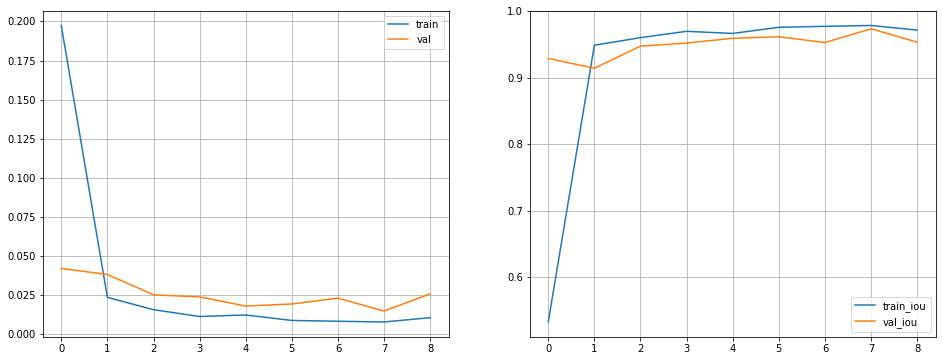

In [ ]:
for i in range(num_epochs):
    
    if i>0:
         print("Epoch %d/%d\t Loss mean: %f\t IoU mean: %f"% \
               (i, num_epochs, epoch_loss, epoch_iou))
         print("Epoch %d/%d\t Val Loss mean: %f\t Val IoU mean: %f"% \
               (i, num_epochs, val_loss, val_iou))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['val_loss'], label='val')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_iou'], label='train_iou')
         plt.plot(hist['val_iou'], label='val_iou')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_ious = []
    val_losses = []
    val_ious = []
    
    model.train()
    for k, (img, mask) in enumerate(train_loader):  
        optimizer.zero_grad()
        # print(img.shape, mask.shape)
        y_pred = model(img.cuda())
        # print(y_pred.shape, mask.shape)
        loss = criterion(y_pred.cuda(), mask.cuda())
        
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  mask.numpy())
        epoch_ious.append(iou)
        
        
        #if k%5 == 0:
        #    print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_iou = np.mean(np.array(epoch_ious))
    hist['train_iou'].append(epoch_iou)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        model.eval()
        for k, (img, mask) in enumerate(val_loader):
            y_pred = model(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            val_losses.append(loss.item())
            val_ious.append(iou)
            
            
            
    val_loss = np.mean(np.array(val_losses))
    val_iou = np.mean(np.array(val_ious))
    hist['val_loss'].append(val_loss)
    hist['val_iou'].append(val_iou)
    if i < (num_epochs-1):
        clear_output()

torch.Size([1, 3, 512, 512])
(512, 512)


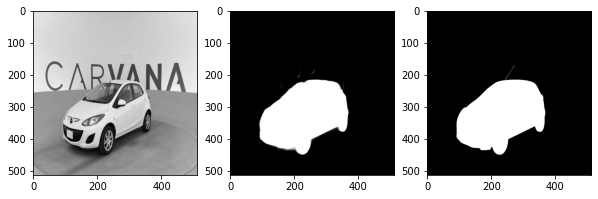

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(train_features.shape)
y_features = model(train_features.cuda())

plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
im = train_features[0][0]
print(im.detach().cpu().numpy().shape)
plt.imshow(im.detach().cpu().numpy(), 'gray')
plt.subplot(1,3,2)
mask = y_features[0][0]
plt.imshow(mask.detach().cpu().numpy(), 'gray')
plt.subplot(1,3,3)
mask1 = train_labels[0][0]
plt.imshow(mask1.detach().cpu().numpy(), 'gray')

In [ ]:
torch.save(model.state_dict(), 'model.pt')  # Сохранение весов модели